In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
import glob
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit

In [2]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Binned data

In [5]:
dat_full = edit.load_pickle('/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/100x100_binned_catalogs.pkl')

In [6]:
dat_partial = edit.load_pickle('/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/100x100_binned_catalogs_fsky_div_10.pkl')

In [8]:
N_full = np.array(dat_full[3])
N_partial = np.array(dat_partial[3])

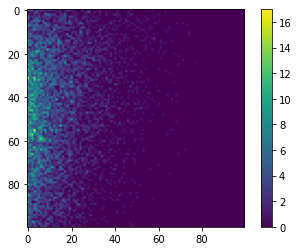

In [13]:
plt.imshow(N_partial[0])
plt.colorbar()

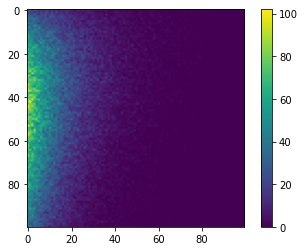

In [14]:
plt.imshow(N_full[0])
plt.colorbar()

In [ ]:
N = np.array(dat[3])
N_new = N.reshape(1000,900)

# Prediction

In [26]:
n_z_bin = 30
n_logm_bin = n_z_bin
z_corner = np.linspace(0.2, 1., n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
Z_bin, logMass_bin = binning(z_corner), binning(logm_corner)

In [27]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
print(clc.f_sky)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
Halo_bias = clc.halo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, N_th = Abundance, method = 'simps')

0.25


In [7]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [8]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin, Abundance, Halo_bias, Sij)/clc.f_sky

In [9]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [10]:
mu_list = Abundance.flatten()
var_SSC_list = Sample_covariance.diagonal()
MVP = mvp_pdf.MVP(mu_list, var_SSC_list)
MVP._set_axis(5, mu_list, var_SSC_list)
N_, P_MVP = MVP.p_mvp(mu_list, var_SSC_list)

/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/mvp_pdf.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  P_MVP = np.array([P_MVP_table[indexes] for indexes in self.split_indexes])


(array([621.,  85.,  49.,  44.,  31.,  22.,  17.,  17.,   9.,   5.]),
 array([  0. ,  74.1, 148.2, 222.3, 296.4, 370.5, 444.6, 518.7, 592.8,
        666.9, 741. ]),
 <a list of 10 Patch objects>)

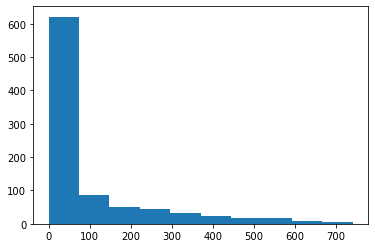

In [11]:
plt.hist(N_new[0].flatten())

[200.         204.04040404 208.08080808 212.12121212 216.16161616
 220.2020202  224.24242424 228.28282828 232.32323232 236.36363636
 240.4040404  244.44444444 248.48484848 252.52525253 256.56565657
 260.60606061 264.64646465 268.68686869 272.72727273 276.76767677
 280.80808081 284.84848485 288.88888889 292.92929293 296.96969697
 301.01010101 305.05050505 309.09090909 313.13131313]
[ 7.69798658 11.04697987 14.39597315 17.74496644 21.09395973 24.44295302
 27.79194631 31.1409396  34.48993289 37.83892617 41.18791946 44.53691275]
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5]


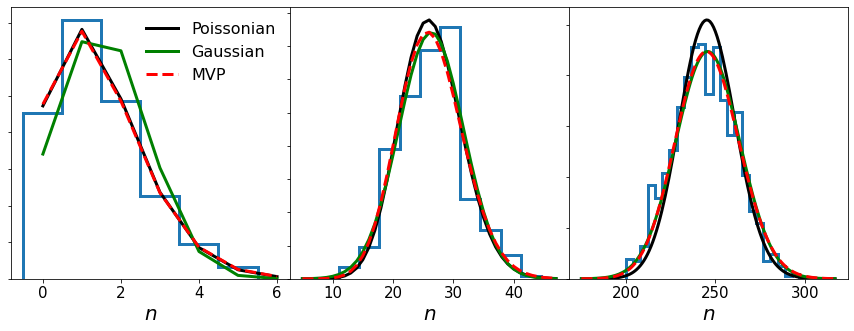

In [12]:
k = 0
intervals = [[1,2],[20,30],[200, 600]]
interval_done = [False, False, False]
bins = [np.arange(10)-.5, np.linspace(1,500,150), np.linspace(intervals[2][0],intervals[2][1],100)]
fig, ax = plt.subplots(1, 3, figsize = (15,5))
plt.subplots_adjust(wspace = 0)
plt.rcParams['axes.axisbelow'] = True
for n, p_mvp, i in zip(N_, P_MVP, np.arange(len(N_))):
    mu = mu_list[i]
    rv = poisson(mu)
    n_sigma = 4
    mask = (n > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(n < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
    poisson_ = rv.pmf(n)
    pdf = multivariate_normal.pdf(n, mean=mu, cov=var_SSC_list[i] + mu)
    for s, interval in enumerate(intervals):
        if (mu > interval[0])*(mu < interval[1])*(interval_done[s] == False):
            interval_done[s] = True
            ax[s].plot(n[mask], poisson_[mask], '-k', linewidth = 3, label = 'Poissonian')
            ax[s].plot(n[mask], pdf[mask]/np.sum(pdf), '-g', linewidth = 3, label = 'Gaussian')
            ax[s].plot(n[mask], p_mvp[mask], '--r', linewidth = 3, label = 'MVP')
            mask_bin = (bins[s] > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(bins[s] < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
            bins_corrected = bins[s][mask_bin]
            print(bins_corrected)
            ax[s].hist(N_new[:,i], density=True, bins = bins_corrected, histtype = 'step', linewidth = 3, alpha = 1)
            #a, b = np.histogram(N_new[:,i], bins = bins_corrected)
            #bin_middle = [(bins_corrected[i] + bins_corrected[i+1])/2 for i in range(len(bins_corrected)-1)]
            #a_normalized = a/(sum(a)*(bins_corrected[1]-bins_corrected[0]))
            #ax[s].plot(bin_middle, a_normalized, label = 'histogram')
            ax[s].set_xlabel(r'$n$', fontsize = 20)
            ax[s].tick_params(axis='both', which = 'major', labelsize= 15)
            if s == 0:
                ax[s].legend(frameon = False, framealpha = 1, fontsize = 16, loc = 'best')
            plt.setp( ax[s].get_yticklabels(), visible=False )
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/high_n.pdf', bbox_inches='tight', dpi=300)

In [13]:
#where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
#cat = glob.glob(where_cat)
#data_Fumagalli = []
#for i,c in enumerate(cat):
#    if i>1000: break
#    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
#    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.677
#    Ns, mass_edges, z_edges, im  = plt.hist2d(np.log10(Mvir),redshift, 
#                                       bins=[logm_corner,z_corner], cmin=0)
#    data_Fumagalli.append(Ns.T.flatten())